In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
import seaborn as sns
import random
import nltk
import time
import datetime
import os
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/napat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('join.csv')
df

,Unnamed: 0,meme_id,meme_label,text,image_url,separated_text,transformed_text
0,0,0,Drake Hotline Bling,my mom when i play with my phone for 30 minute...,//i.imgflip.com/3xd5o0.jpg,my mom when i play with my phone for 30 minute...,my mom when i play with my phone for 30 minute...
1,1,0,Drake Hotline Bling,Doing your own research for a test Copy and pa...,//i.imgflip.com/3xctnx.jpg,Doing your own research for a test <SEP> Copy ...,doing your own research for a test <SEP> copy ...
2,2,0,Drake Hotline Bling,"1,000,000 followers on tik tok 1 point on imgflip",//i.imgflip.com/3wu3bd.jpg,"1,000,000 followers on tik tok <SEP> 1 point o...","1,000,000 followers on tik tok <SEP> 1 point o..."
3,3,0,Drake Hotline Bling,Making original memes Following the idea of an...,//i.imgflip.com/3xb1dj.jpg,Making original memes <SEP> Following the idea...,making original memes <SEP> following the idea...
4,4,0,Drake Hotline Bling,Upvote begging Upvoting your own meme on diffe...,//i.imgflip.com/3xjb2g.jpg,Upvote begging <SEP> Upvoting your own meme on...,upvote begging <SEP> upvoting your own meme on...
...,...,...,...,...,...,...,...
21541,27035,99,Sparta Leonidas,YOU ATE ALL MY BEANS NIGBA,//i.imgflip.com/2kwtje.jpg,YOU ATE ALL MY BEANS <SEP> NIGBA,you ate all my beans <SEP> nigba
21542,27036,99,Sparta Leonidas,ARTICLE 13 PASSED WE WILL FIGHT UNTIL THE END,//i.imgflip.com/36vami.jpg,ARTICLE 13 PASSED WE <SEP> WILL FIGHT UNTIL TH...,article 13 passed we <SEP> will fight until th...
21543,27037,99,Sparta Leonidas,NO RETREAT....... NO...,//i.imgflip.com/131fnv.jpg,NO RETREAT....... NO SURRENDER <SEP> THAT IS B...,no retreat no surrender <SEP> that is blackhaw...
21544,27038,99,Sparta Leonidas,TTW MUM FORGOT TO PACK CRISPS WITH LUNCH,//i.imgflip.com/2lrvrg.jpg,TTW MUM FORGOT TO PACK CRISPS <SEP> WITH LUNCH,ttw mum forgot to pack crisps <SEP> with lunch


/home/napat/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'lenght of each sentence')

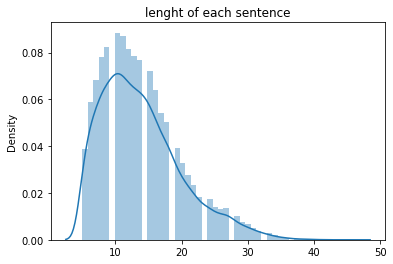

In [3]:
doc_lengths = []

for i in range(len(df)):

    # get rough token count distribution
    tokens = nltk.word_tokenize(df.iloc[i]['text'])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
plt.title('lenght of each sentence')

## GPT2 tokenizer 

In [4]:
additional_special_class_meme = ['['+meme+']' for meme in np.unique(df['meme_label'].values)]
additional_special_class_meme

['[Am I The Only One Around Here]',
 '[Bad Luck Brian]',
 '[Drake Hotline Bling]',
 '[Grandma Finds The Internet]',
 '[Matrix Morpheus]',
 '[Philosoraptor]',
 '[Sleeping Shaq]',
 '[Sparta Leonidas]',
 '[The Rock Driving]',
 '[The Scroll Of Truth]',
 '[Trump Bill Signing]',
 '[Woman Yelling At Cat]']

In [5]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', sep_token ='<SEP>',
                                          pad_token='<|pad|>',additional_special_tokens = additional_special_class_meme) #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [15]:
test = 'you ate all my beans <SEP> nigba'
tokenizer(test)

{'input_ids': [5832, 15063, 477, 616, 16567, 50258, 77, 328, 7012], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
tokenizer.convert_ids_to_tokens([705])

["Ġ'"]

In [8]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50259


In [6]:
class GPT2Dataset(Dataset):

  def __init__(self, df, tokenizer, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.df = df 
    for i in range(len(self.df)):
      text = '<|startoftext|>'+ '[' + df.iloc[i]['meme_label']+ ']'  + df.iloc[i]['transformed_text'] + '<|endoftext|>'
      encodings_dict = tokenizer(text, truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [7]:
dataset = GPT2Dataset(df,tokenizer)
# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

19,391 training samples
2,155 validation samples


In [19]:
dataset[0][0]

tensor([50257, 50262,  1820,  1995,   618,  1312,   711,   351,   616,  3072])

In [20]:
tokenizer.convert_ids_to_tokens([ 50257, 50262,  1820,  1995,   618,  1312,   711,   351,   616,  3072])

['<|startoftext|>',
 '[Drake Hotline Bling]',
 'my',
 'Ġmom',
 'Ġwhen',
 'Ġi',
 'Ġplay',
 'Ġwith',
 'Ġmy',
 'Ġphone']

In [8]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
batch_size = 2
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size ,# Trains with this batch size.
            pin_memory =True,
            num_workers = 4
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            pin_memory =True,
            num_workers = 4
        )

In [9]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [10]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [11]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [12]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [13]:
total_t0 = time.time()

training_stats = []

model = model.to(device)
scaler = torch.cuda.amp.GradScaler()
prev_val_loss = 1000
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        
        with torch.cuda.amp.autocast():
            outputs = model(  b_input_ids,
                        labels=b_labels, 
                        attention_mask = b_masks,
                        token_type_ids=None
                      )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            text = '<|startoftext|>'+ additional_special_class_meme[random.randint(0,11)]
            generated = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
            generated = generated.to(device)

            sample_outputs = model.generate(
                                    input_ids = generated,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 20,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            #print(generated,sample_outputs)
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=False)}')
            #break
            model.train()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

#         loss.backward()

#         optimizer.step()

        scheduler.step()
    
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
    
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    ## save model
    if avg_val_loss < prev_val_loss:
        output_dir = '/home/napat/nlp/weight_gen'

        # Create output directory if needed
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        print("Saving model to %s" % output_dir)

        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
    prev_val_loss = avg_val_loss#.copy()
    
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
## warning ref 
## https://discuss.pytorch.org/t/userwarning-detected-call-of-lr-scheduler-step-before-optimizer-step-in-pytorch-1-1-0-and-later-you-should-call-them-in-the-opposite-order-optimizer-step-before-lr-scheduler-step/88295/4


======== Epoch 1 / 5 ========
Training...


/home/napat/anaconda3/envs/torch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,696. Loss: 0.1392260491847992.   Elapsed: 0:00:14.
Example output: <|startoftext|> [Trump Bill Signing]  with to the in ana for thea<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,696. Loss: 0.19087696075439453.   Elapsed: 0:00:28.
Example output: <|startoftext|> [Bad Luck Brian]  i said to i just to someone i don like me<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,696. Loss: 0.15790009498596191.   Elapsed: 0:00:42.
Example output: <|startoftext|> [Am I The Only One Around Here] what if i told you <SEP> that they were just a [Woman Yelling At Cat]  to have a holiday<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,696. Loss: 0.11153391748666763.   Elapsed: 0:00:56.
Example output: <|startoftext|> [Woman Yelling At Cat] i didn't happen to be a girl? [Matrix Morpheus] it did happen to be a girl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,696. Loss: 0.14169806241989136.   Elapsed: 0:01:11.
Example output: <|startoftext|> [Matrix Morpheus] i must make cookies to send you to a friend<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,696. Loss: 0.12243834137916565.   Elapsed: 0:01:25.
Example output: <|startoftext|> [Grandma Finds The Internet] what if i told you [Matrix Morpheus] you can just write a name by using a phrase, "


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,696. Loss: 0.10096701234579086.   Elapsed: 0:01:39.
Example output: <|startoftext|> [Grandma Finds The Internet] you know [Drake Hotline Bling] that's true, but you aren't actually the one with an


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,696. Loss: 0.16108007729053497.   Elapsed: 0:01:53.
Example output: <|startoftext|> [Drake Hotline Bling] i thought it was a way to kill them <SEP> what if i told you that hei


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,696. Loss: 0.15184839069843292.   Elapsed: 0:02:07.
Example output: <|startoftext|> [Woman Yelling At Cat] when i see you <SEP> you like the " t and " t "<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,696. Loss: 0.15218214690685272.   Elapsed: 0:02:21.
Example output: <|startoftext|> [Bad Luck Brian] halloween<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,696. Loss: 0.10070530325174332.   Elapsed: 0:02:35.
Example output: <|startoftext|> [Trump Bill Signing] why am i the only one around here who gets hit by a bus? ? 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,696. Loss: 0.09716461598873138.   Elapsed: 0:02:49.
Example output: <|startoftext|> [Woman Yelling At Cat] me trying to send my first missx on the page <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,696. Loss: 0.15388716757297516.   Elapsed: 0:03:04.
Example output: <|startoftext|> [The Rock Driving] what if i told you <SEP> that my sister thinks we are the only one around here who


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,696. Loss: 0.13975933194160461.   Elapsed: 0:03:18.
Example output: <|startoftext|> [Bad Luck Brian] am i the only one around here <SEP> who thinks that women have "too much control over


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,696. Loss: 0.10111194849014282.   Elapsed: 0:03:32.
Example output: <|startoftext|> [The Scroll Of Truth] me when i do a job <SEP> but i get less paid<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,696. Loss: 0.14696910977363586.   Elapsed: 0:03:46.
Example output: <|startoftext|> [Sleeping Shaq] finally gets some good pics of her memes <SEP> not bad<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,696. Loss: 0.09169535338878632.   Elapsed: 0:04:00.
Example output: <|startoftext|> [Am I The Only One Around Here] if anime developers want to <|pad|> make games with aliens and other aliens then go back to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,696. Loss: 0.08193547278642654.   Elapsed: 0:04:15.
Example output: <|startoftext|> [Am I The Only One Around Here] hey i said , you don t need to watch the movie? [Woman Yelling At Cat] i was just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,696. Loss: 0.13585197925567627.   Elapsed: 0:04:29.
Example output: <|startoftext|> [Bad Luck Brian] what if i told you <SEP> the last thing your mom needs to put on your pants is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,696. Loss: 0.1069338321685791.   Elapsed: 0:04:43.
Example output: <|startoftext|> [Grandma Finds The Internet] me thinking something in my brain that tells me <SEP> you that brain structure makes a difference<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,696. Loss: 0.11716554313898087.   Elapsed: 0:04:57.
Example output: <|startoftext|> [Grandma Finds The Internet] what if i told you <SEP> the only reason you read this site is because you're


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,696. Loss: 0.077317975461483.   Elapsed: 0:05:11.
Example output: <|startoftext|> [The Rock Driving] if you put on your glasses, can you look in the mirror and your glasses? <SEP>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,696. Loss: 0.07038130611181259.   Elapsed: 0:05:25.
Example output: <|startoftext|> [The Scroll Of Truth] who is a good friend of the boys <SEP> when there's only one on the squad


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,696. Loss: 0.12748628854751587.   Elapsed: 0:05:39.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> that dont wanna have a bad joke<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,696. Loss: 0.05893377214670181.   Elapsed: 0:05:54.
Example output: <|startoftext|> [The Rock Driving] what if i told you <SEP> i am not gay<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,696. Loss: 0.17083165049552917.   Elapsed: 0:06:08.
Example output: <|startoftext|> [Grandma Finds The Internet] there is a thing that's been antonym to all the comments <SEP> but i


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,696. Loss: 0.08044201880693436.   Elapsed: 0:06:22.
Example output: <|startoftext|> [Woman Yelling At Cat] what if i told you <SEP> there is no truth<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,696. Loss: 0.08664269745349884.   Elapsed: 0:06:36.
Example output: <|startoftext|> [Trump Bill Signing] you can't find <SEP> a comment<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,696. Loss: 0.055744972079992294.   Elapsed: 0:06:50.
Example output: <|startoftext|> [Woman Yelling At Cat] you know what i hate <SEP> the first time i can walk a dog with a child<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,696. Loss: 0.11054211109876633.   Elapsed: 0:07:04.
Example output: <|startoftext|> [The Rock Driving] i just said you can't tell a woman <SEP> you're gay because she '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,696. Loss: 0.11735124886035919.   Elapsed: 0:07:18.
Example output: <|startoftext|> [Sleeping Shaq] where are you getting to when it comes <SEP> on a snowflore day<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,696. Loss: 0.07309615612030029.   Elapsed: 0:07:32.
Example output: <|startoftext|> [Grandma Finds The Internet] that moment i thought it was a bad meme <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,696. Loss: 0.1197378933429718.   Elapsed: 0:07:46.
Example output: <|startoftext|> [Sparta Leonidas] i want a big ass <SEP> my mom i want a big ass in my ass i want


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,696. Loss: 0.08923555910587311.   Elapsed: 0:08:01.
Example output: <|startoftext|> [The Scroll Of Truth] you wasted 15 years but we will never die <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,696. Loss: 0.09259648621082306.   Elapsed: 0:08:15.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> you can build a high wall<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,696. Loss: 0.07977353781461716.   Elapsed: 0:08:29.
Example output: <|startoftext|> [Am I The Only One Around Here] when you look at memes <SEP> and someone says " " m " memes?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,696. Loss: 0.04322471842169762.   Elapsed: 0:08:43.
Example output: <|startoftext|> [Drake Hotline Bling] mom making another meme <SEP> me not doing it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,696. Loss: 0.11745761334896088.   Elapsed: 0:08:57.
Example output: <|startoftext|> [Woman Yelling At Cat] i will not stop you from eating your cookies this year <SEP> i am your mom<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,696. Loss: 0.1129264086484909.   Elapsed: 0:09:11.
Example output: <|startoftext|> [Sleeping Shaq] what i like to say is the same as a <SEP> brian jones<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,696. Loss: 0.09056732803583145.   Elapsed: 0:09:25.
Example output: <|startoftext|> [Philosoraptor] if the government's been in the middle of a world <SEP> if only two worlds were


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,696. Loss: 0.06375114619731903.   Elapsed: 0:09:40.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that in the age of gena people we know gena


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,696. Loss: 0.1491858810186386.   Elapsed: 0:09:54.
Example output: <|startoftext|> [Drake Hotline Bling] go ahead and get killed <SEP> go ahead and get killed<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,696. Loss: 0.09025193005800247.   Elapsed: 0:10:08.
Example output: <|startoftext|> [Grandma Finds The Internet] no matter what the " what " is my profile picture " i only have a profile picture


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,696. Loss: 0.11177200078964233.   Elapsed: 0:10:22.
Example output: <|startoftext|> [Philosoraptor] if i told you <SEP> the first amendment [Am I The Only One Around Here] is it possible to change your laws?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,696. Loss: 0.10716423392295837.   Elapsed: 0:10:36.
Example output: <|startoftext|> [Bad Luck Brian] tries to stay home during the national anthem <SEP> gets sent to the police<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,696. Loss: 0.0694257915019989.   Elapsed: 0:10:50.
Example output: <|startoftext|> [Bad Luck Brian] teachers make him the first [Matrix Morpheus] teacher in the class to have a kid for a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,696. Loss: 0.13346222043037415.   Elapsed: 0:11:04.
Example output: <|startoftext|> [Sleeping Shaq] fortnite <SEP> i have 5.6 million players?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,696. Loss: 0.08826401829719543.   Elapsed: 0:11:18.
Example output: <|startoftext|> [Bad Luck Brian] takes a test <SEP> drowns<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,696. Loss: 0.09324096143245697.   Elapsed: 0:11:32.
Example output: <|startoftext|> [Philosoraptor] if your cat is in quarantine <SEP> why aren't some of you eating your cat?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,696. Loss: 0.07198882102966309.   Elapsed: 0:11:46.
Example output: <|startoftext|> [Philosoraptor] i'm sick and tired of how <SEP> mike we need to feel, and can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,696. Loss: 0.12683798372745514.   Elapsed: 0:12:01.
Example output: <|startoftext|> [The Scroll Of Truth] the truth of american government <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,696. Loss: 0.07961177080869675.   Elapsed: 0:12:15.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> you read the top line wrong<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,696. Loss: 0.049293357878923416.   Elapsed: 0:12:29.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> that thinks the media should have the right to take


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,696. Loss: 0.12232476472854614.   Elapsed: 0:12:43.
Example output: <|startoftext|> [Woman Yelling At Cat] suck with <SEP> a great place? ? ? ?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,696. Loss: 0.10434041172266006.   Elapsed: 0:12:57.
Example output: <|startoftext|> [Sparta Leonidas] you know my dad is a cat <SEP> i am a dog<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,696. Loss: 0.09555694460868835.   Elapsed: 0:13:11.
Example output: <|startoftext|> [The Rock Driving] i have a birthday <SEP> a lot of things on all my cookies?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,696. Loss: 0.08355709165334702.   Elapsed: 0:13:25.
Example output: <|startoftext|> [Bad Luck Brian] finally gets hired as a [Sparta Leonidas] voted<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,696. Loss: 0.09604664891958237.   Elapsed: 0:13:39.
Example output: <|startoftext|> [Sleeping Shaq] my mom playing minecraft <SEP> me using the minecraftcraft map<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,696. Loss: 0.04115520790219307.   Elapsed: 0:13:53.
Example output: <|startoftext|> [Bad Luck Brian] says he made a video that killed a man he couldn't spell <SEP> gets killed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,696. Loss: 0.09855007380247116.   Elapsed: 0:14:07.
Example output: <|startoftext|> [The Rock Driving] did that just you get married to a virgin?        


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,696. Loss: 0.08414474874734879.   Elapsed: 0:14:21.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that u're not a meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,696. Loss: 0.14761903882026672.   Elapsed: 0:14:35.
Example output: <|startoftext|> [Trump Bill Signing] i like the good ones <SEP> i thought it was a bad guy<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,696. Loss: 0.052767109125852585.   Elapsed: 0:14:49.
Example output: <|startoftext|> [The Scroll Of Truth] you don't call a britishian <SEP> and i'm british


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,696. Loss: 0.14850986003875732.   Elapsed: 0:15:03.
Example output: <|startoftext|> [Philosoraptor] do the homeless <SEP> have a big dick?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,696. Loss: 0.08895562589168549.   Elapsed: 0:15:17.
Example output: <|startoftext|> [The Scroll Of Truth] you wasted 15 years of your life in a living room with a living room <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,696. Loss: 0.07262665033340454.   Elapsed: 0:15:31.
Example output: <|startoftext|> [Grandma Finds The Internet] this is a <SEP> pewdiepie<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,696. Loss: 0.13531522452831268.   Elapsed: 0:15:45.
Example output: <|startoftext|> [Woman Yelling At Cat] i was sleeping <SEP> i don t even know i am playing fortnite anymore what do


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,696. Loss: 0.09708157926797867.   Elapsed: 0:15:59.
Example output: <|startoftext|> [Bad Luck Brian] studies for the coronavirus <SEP> it s his worstest friend on earth<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,696. Loss: 0.05848195403814316.   Elapsed: 0:16:14.
Example output: <|startoftext|> [Am I The Only One Around Here] my wife's family is just the most old of the <SEP> disappare by their


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,696. Loss: 0.0784202516078949.   Elapsed: 0:16:27.
Example output: <|startoftext|> [Trump Bill Signing] i'm calling my <SEP> grand brother<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,696. Loss: 0.07877488434314728.   Elapsed: 0:16:41.
Example output: <|startoftext|> [Grandma Finds The Internet] when grandma sees that " siri " at school? <SEP> i'm deaf  "


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,696. Loss: 0.09620082378387451.   Elapsed: 0:16:54.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that all liberals only vote for you for the media<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,696. Loss: 0.09603558480739594.   Elapsed: 0:17:08.
Example output: <|startoftext|> [Bad Luck Brian] discovers her panties <SEP> gets an amazing movie<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,696. Loss: 0.11975117772817612.   Elapsed: 0:17:21.
Example output: <|startoftext|> [Grandma Finds The Internet] at the end of the world, <SEP> somebody's calling that be you, not


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,696. Loss: 0.09541572630405426.   Elapsed: 0:17:35.
Example output: <|startoftext|> [Bad Luck Brian] thinks he's gonna die <SEP> gets reincarnated as a meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,696. Loss: 0.14318397641181946.   Elapsed: 0:17:48.
Example output: <|startoftext|> [Sleeping Shaq] my mom <SEP> school kid?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,696. Loss: 0.10908598452806473.   Elapsed: 0:18:02.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> you can live free toilet money for every other person<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,696. Loss: 0.09353765100240707.   Elapsed: 0:18:15.
Example output: <|startoftext|> [Sparta Leonidas] when you die and all the people <SEP> are in death or death<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,696. Loss: 0.11194053292274475.   Elapsed: 0:18:29.
Example output: <|startoftext|> [Trump Bill Signing] crapping the memes <SEP> there will be a meme on the front page<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,696. Loss: 0.06326021254062653.   Elapsed: 0:18:42.
Example output: <|startoftext|> [Philosoraptor] why did the dinosaur go to jail? <SEP> if he had died<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,696. Loss: 0.10634993761777878.   Elapsed: 0:18:56.
Example output: <|startoftext|> [Drake Hotline Bling] listens to tv at summer camp and stay home <SEP> listens to tv at summer vacation


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,696. Loss: 0.05668705329298973.   Elapsed: 0:19:09.
Example output: <|startoftext|> [Philosoraptor] what if we just made a movie for us <SEP> and were still doing it all the other


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,696. Loss: 0.0795457661151886.   Elapsed: 0:19:23.
Example output: <|startoftext|> [Philosoraptor] does that mean you had covid 19 <SEP> it's something you're talking about


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,696. Loss: 0.16606123745441437.   Elapsed: 0:19:36.
Example output: <|startoftext|> [Grandma Finds The Internet] wait im a virgin <SEP> is that it a virginian?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,696. Loss: 0.08149953931570053.   Elapsed: 0:19:50.
Example output: <|startoftext|> [Trump Bill Signing] anybody else want to <SEP> know if this is imgflip? and dick<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,696. Loss: 0.16688694059848785.   Elapsed: 0:20:03.
Example output: <|startoftext|> [Matrix Morpheus] i'm a <SEP> good thing to do a job you just have to do to you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,696. Loss: 0.12838046252727509.   Elapsed: 0:20:17.
Example output: <|startoftext|> [Woman Yelling At Cat] you found my meme i love <SEP> no meme you found<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,696. Loss: 0.09736202657222748.   Elapsed: 0:20:30.
Example output: <|startoftext|> [Trump Bill Signing] we will build <SEP> cussa america<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,696. Loss: 0.09465361386537552.   Elapsed: 0:20:44.
Example output: <|startoftext|> [Trump Bill Signing] its <SEP> wtf  ?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,696. Loss: 0.09252852946519852.   Elapsed: 0:20:57.
Example output: <|startoftext|> [Bad Luck Brian] parents send suicide note to them to their parents, <SEP> they believe they would like their name


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,696. Loss: 0.15502043068408966.   Elapsed: 0:21:11.
Example output: <|startoftext|> [The Scroll Of Truth] you should be the last <SEP> toilet paper<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,696. Loss: 0.18541111052036285.   Elapsed: 0:21:24.
Example output: <|startoftext|> [Trump Bill Signing]  one on because ining get <SEP>  to your you don <SEP>  you your a you at to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,696. Loss: 0.1607734113931656.   Elapsed: 0:21:38.
Example output: <|startoftext|> [Drake Hotline Bling] 'a t i told i to '?'if [Philosoraptor] <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,696. Loss: 0.1400594860315323.   Elapsed: 0:21:51.
Example output: <|startoftext|> [The Rock Driving] ? <SEP>  one people <SEP> whoam'you? <SEP>  a? <SEP>  <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,696. Loss: 0.25795263051986694.   Elapsed: 0:22:05.
Example output: <|startoftext|> [Woman Yelling At Cat]  my you of that the it you to? 'what? are<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,696. Loss: 0.13266721367835999.   Elapsed: 0:22:18.
Example output: <|startoftext|> [Grandma Finds The Internet] s one i<|endoftext|>

  Average training loss: 0.13
  Training epoch took: 0:22:31

Running Validation...
  Validation Loss: 0.16
  Validation took: 0:01:09
Saving model to /home/napat/nlp/weight_gen

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,696. Loss: 0.11104746162891388.   Elapsed: 0:00:14.
Example output: <|startoftext|> [Drake Hotline Bling] <SEP> so the,'toi your people is<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,696. Loss: 0.1636768877506256.   Elapsed: 0:00:28.
Example output: <|startoftext|> [Sparta Leonidas] <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,696. Loss: 0.18462398648262024.   Elapsed: 0:00:42.
Example output: <|startoftext|> [Sleeping Shaq] what <SEP> , <SEP>  you a<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,696. Loss: 0.11778722703456879.   Elapsed: 0:00:56.
Example output: <|startoftext|> [Matrix Morpheus] when a you like, if'are'for me one you i toam are the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,696. Loss: 0.1533745378255844.   Elapsed: 0:01:10.
Example output: <|startoftext|> [Trump Bill Signing] me the <SEP> when in <SEP> fl the my<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,696. Loss: 0.19432692229747772.   Elapsed: 0:01:24.
Example output: <|startoftext|> [Woman Yelling At Cat] s you i <SEP> if is <SEP>  that on of [The Rock Driving]  it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,696. Loss: 0.23164331912994385.   Elapsed: 0:01:39.
Example output: <|startoftext|> [The Rock Driving] whatwhat a it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,696. Loss: 0.16734318435192108.   Elapsed: 0:01:53.
Example output: <|startoftext|> [Grandma Finds The Internet] it i the t'[Am I The Only One Around Here] there my is on to told be up t the the not


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,696. Loss: 0.171616330742836.   Elapsed: 0:02:07.
Example output: <|startoftext|> [Trump Bill Signing] am <SEP> if the s s is'[Drake Hotline Bling]  to can s here that <SEP>  told not for


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,696. Loss: 0.21320706605911255.   Elapsed: 0:02:21.
Example output: <|startoftext|> [Philosoraptor] to a only a are're do you one for the the the <SEP> my to here


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,696. Loss: 0.14367160201072693.   Elapsed: 0:02:36.
Example output: <|startoftext|> [Am I The Only One Around Here] that told i a the i the <SEP> what but the <SEP> you you to s in you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,696. Loss: 0.13167612254619598.   Elapsed: 0:02:51.
Example output: <|startoftext|> [Grandma Finds The Internet] if a't m of you can you the you you one to make m<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,696. Loss: 0.08246046304702759.   Elapsed: 0:03:06.
Example output: <|startoftext|> [Am I The Only One Around Here] am m the m i m have the m told'only never the t <SEP> does you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,696. Loss: 0.15829084813594818.   Elapsed: 0:03:21.
Example output: <|startoftext|> [Philosoraptor] if all the be i good? <SEP> that time??<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,696. Loss: 0.14058908820152283.   Elapsed: 0:03:36.
Example output: <|startoftext|> [Sleeping Shaq] and you not m the earth? of a your one here<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,696. Loss: 0.14463017880916595.   Elapsed: 0:03:51.
Example output: <|startoftext|> [Matrix Morpheus] it be go a a new na <SEP> d, <SEP> a are the second?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,696. Loss: 0.06101294606924057.   Elapsed: 0:04:06.
Example output: <|startoftext|> [Bad Luck Brian] when you that people <SEP> it they get my name and<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,696. Loss: 0.1053963229060173.   Elapsed: 0:04:21.
Example output: <|startoftext|> [Grandma Finds The Internet] what if you see are you can t get up a toiletian by the real<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,696. Loss: 0.16594627499580383.   Elapsed: 0:04:36.
Example output: <|startoftext|> [The Scroll Of Truth] am i's the only one one around here <SEP> get a shit?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,696. Loss: 0.08346067368984222.   Elapsed: 0:04:52.
Example output: <|startoftext|> [Woman Yelling At Cat] what is a man " " are a person " that you eat you are the meme i


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,696. Loss: 0.1288965344429016.   Elapsed: 0:05:07.
Example output: <|startoftext|> [Philosoraptor] can you wear black man <SEP> then wear a legback with black man<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,696. Loss: 0.08606599271297455.   Elapsed: 0:05:22.
Example output: <|startoftext|> [Grandma Finds The Internet] if we're dead at least    's <SEP> but this girl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,696. Loss: 0.16774994134902954.   Elapsed: 0:05:37.
Example output: <|startoftext|> [Trump Bill Signing] your life is getting more to get you <SEP> kill yourself<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,696. Loss: 0.12437139451503754.   Elapsed: 0:05:51.
Example output: <|startoftext|> [Sparta Leonidas] doughieber <SEP> look like you can't be cool<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,696. Loss: 0.1737315058708191.   Elapsed: 0:06:05.
Example output: <|startoftext|> [Sleeping Shaq] when you make a meme <SEP> " it didn't even feature down memes "<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,696. Loss: 0.12452641129493713.   Elapsed: 0:06:19.
Example output: <|startoftext|> [Trump Bill Signing] the media is a facist <SEP> me building a wall wall of wall<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,696. Loss: 0.05381366237998009.   Elapsed: 0:06:33.
Example output: <|startoftext|> [Sparta Leonidas] how can i go to the stairs <SEP> beater<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,696. Loss: 0.0986533910036087.   Elapsed: 0:06:47.
Example output: <|startoftext|> [Drake Hotline Bling] tiktok tok, no wifi, phone, download a preiktik


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,696. Loss: 0.12746258080005646.   Elapsed: 0:07:01.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you that it won t move into your own house <SEP> and you '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,696. Loss: 0.0947074145078659.   Elapsed: 0:07:16.
Example output: <|startoftext|> [Drake Hotline Bling] people in the past <SEP> people in the past<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,696. Loss: 0.08741433918476105.   Elapsed: 0:07:30.
Example output: <|startoftext|> [Grandma Finds The Internet] when u look at a website <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,696. Loss: 0.161464661359787.   Elapsed: 0:07:44.
Example output: <|startoftext|> [Woman Yelling At Cat] i've to tell you im pregnant i'll never see the toilet paper <SEP> dad


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,696. Loss: 0.09654681384563446.   Elapsed: 0:07:58.
Example output: <|startoftext|> [The Rock Driving] it will be fine you <SEP> this is where the u s<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,696. Loss: 0.1452488750219345.   Elapsed: 0:08:12.
Example output: <|startoftext|> [The Rock Driving] what does the best movie about the same thing about how <SEP> a movie about the movies about


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,696. Loss: 0.07926090806722641.   Elapsed: 0:08:26.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you that if women only have to be allowed to be at their own


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,696. Loss: 0.07256070524454117.   Elapsed: 0:08:41.
Example output: <|startoftext|> [Woman Yelling At Cat] you want me to stay home, <SEP> i have a big drink at your store as you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,696. Loss: 0.06801331043243408.   Elapsed: 0:08:55.
Example output: <|startoftext|> [The Scroll Of Truth] why is everyone in my room <SEP> a man that's gay<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,696. Loss: 0.08178558945655823.   Elapsed: 0:09:09.
Example output: <|startoftext|> [Sleeping Shaq] when people take down all caps on a side of a ship, rolls of coffee and gets


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,696. Loss: 0.18653947114944458.   Elapsed: 0:09:23.
Example output: <|startoftext|> [The Scroll Of Truth] " a hot cup, hot cup, hot cup, hot cup and cold cup is <SEP>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,696. Loss: 0.10475420951843262.   Elapsed: 0:09:37.
Example output: <|startoftext|> [Sleeping Shaq] me trying to stay at school to keep my parents home <SEP> so i can't have


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,696. Loss: 0.06525661051273346.   Elapsed: 0:09:51.
Example output: <|startoftext|> [Philosoraptor] if you got drunk wrong with your math book? <SEP> does that mean you are rich?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,696. Loss: 0.07796058803796768.   Elapsed: 0:10:06.
Example output: <|startoftext|> [Grandma Finds The Internet] when yewieew looks at memes <SEP> and memes with a meme template<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,696. Loss: 0.09705227613449097.   Elapsed: 0:10:20.
Example output: <|startoftext|> [Drake Hotline Bling] when i'm going to look in the mirror mirror of those <SEP> when i'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,696. Loss: 0.05423460155725479.   Elapsed: 0:10:34.
Example output: <|startoftext|> [The Rock Driving] how was your birthday day at school <SEP> i got off my laptop and i got 7000


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,696. Loss: 0.15128564834594727.   Elapsed: 0:10:49.
Example output: <|startoftext|> [Sparta Leonidas] when u have to know <SEP> of the last piece of cake left<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,696. Loss: 0.10624098032712936.   Elapsed: 0:11:03.
Example output: <|startoftext|> [Bad Luck Brian] last night <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,696. Loss: 0.08837240934371948.   Elapsed: 0:11:17.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> that doesn't watch kevin spacey memes


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,696. Loss: 0.11121682077646255.   Elapsed: 0:11:31.
Example output: <|startoftext|> [Bad Luck Brian] falls in china <SEP> gets arrested by the police<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,696. Loss: 0.0332116037607193.   Elapsed: 0:11:45.
Example output: <|startoftext|> [Drake Hotline Bling] stalker <SEP> talker halker halker<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,696. Loss: 0.12798339128494263.   Elapsed: 0:11:59.
Example output: <|startoftext|> [Trump Bill Signing] sad and chill <SEP> fuuuuuu<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,696. Loss: 0.10578316450119019.   Elapsed: 0:12:13.
Example output: <|startoftext|> [Drake Hotline Bling] go make your money back your money <SEP> make a car do your loan back half of your


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,696. Loss: 0.10096396505832672.   Elapsed: 0:12:28.
Example output: <|startoftext|> [Trump Bill Signing] this meme is useless <SEP> the truth<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,696. Loss: 0.06669658422470093.   Elapsed: 0:12:42.
Example output: <|startoftext|> [Sleeping Shaq] i could win <SEP> my father and i did it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,696. Loss: 0.11892156302928925.   Elapsed: 0:12:56.
Example output: <|startoftext|> [The Scroll Of Truth] this meme is not as good as the past <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,696. Loss: 0.06115804240107536.   Elapsed: 0:13:10.
Example output: <|startoftext|> [Bad Luck Brian] studying <SEP> one another cat<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,696. Loss: 0.038576219230890274.   Elapsed: 0:13:24.
Example output: <|startoftext|> [Sleeping Shaq] teachers when your kid <SEP> teachers when you get your kid in trouble<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,696. Loss: 0.06708414107561111.   Elapsed: 0:13:38.
Example output: <|startoftext|> [Sleeping Shaq] make the great bowl then make the bowl <SEP> make memes       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,696. Loss: 0.05182073265314102.   Elapsed: 0:13:52.
Example output: <|startoftext|> [The Scroll Of Truth] people : i love me <SEP> me : i love mr shrek<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,696. Loss: 0.10861235857009888.   Elapsed: 0:14:06.
Example output: <|startoftext|> [Sparta Leonidas] this is a real game now <SEP> the next generation has corona<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,696. Loss: 0.07432208210229874.   Elapsed: 0:14:20.
Example output: <|startoftext|> [The Rock Driving] hey, where's the nice place <SEP> chungus? ?  ?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,696. Loss: 0.08362317085266113.   Elapsed: 0:14:35.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that the " star wars movies " movie is just the movies


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,696. Loss: 0.11570869386196136.   Elapsed: 0:14:49.
Example output: <|startoftext|> [The Rock Driving] ok, sorry, you can never find any object <SEP> so you can see the object that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,696. Loss: 0.09667663276195526.   Elapsed: 0:15:03.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who thinks i shouldn't see anything bad or


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,696. Loss: 0.09681737422943115.   Elapsed: 0:15:17.
Example output: <|startoftext|> [Trump Bill Signing] when someone asks me to make a meme template <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,696. Loss: 0.08924541622400284.   Elapsed: 0:15:31.
Example output: <|startoftext|> [Woman Yelling At Cat] the moment you hear about your crush <SEP> the time you hear about your crush<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,696. Loss: 0.20052294433116913.   Elapsed: 0:15:45.
Example output: <|startoftext|> [Bad Luck Brian] listing to a joke : i'm not a celebrity this year <SEP> " he '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,696. Loss: 0.059136807918548584.   Elapsed: 0:16:00.
Example output: <|startoftext|> [Trump Bill Signing] just you <SEP> the british were already dead<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,696. Loss: 0.051380857825279236.   Elapsed: 0:16:14.
Example output: <|startoftext|> [The Rock Driving] what are people eating? <SEP> no one cares<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,696. Loss: 0.07950235903263092.   Elapsed: 0:16:28.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> sounds like a person who hates all those women who hates


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,696. Loss: 0.07609663903713226.   Elapsed: 0:16:42.
Example output: <|startoftext|> [Trump Bill Signing] the nsa <SEP> has the russia russia russian republicans are coming<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,696. Loss: 0.04725873842835426.   Elapsed: 0:16:56.
Example output: <|startoftext|> [Philosoraptor] if we have food, <SEP> how come we don't know, are we getting food


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,696. Loss: 0.14105290174484253.   Elapsed: 0:17:10.
Example output: <|startoftext|> [Bad Luck Brian] gets 100k points <SEP> test positive for a test<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,696. Loss: 0.11034344881772995.   Elapsed: 0:17:24.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that the word " rock or roll " is not like rock


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,696. Loss: 0.19726940989494324.   Elapsed: 0:17:38.
Example output: <|startoftext|> [Sleeping Shaq] staying up a good idea <SEP> going away with toilet paper<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,696. Loss: 0.09851188957691193.   Elapsed: 0:17:52.
Example output: <|startoftext|> [Drake Hotline Bling] you will never do your credit card math homework until it <SEP> it's for sparta


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,696. Loss: 0.10091196000576019.   Elapsed: 0:18:07.
Example output: <|startoftext|> [Sparta Leonidas] this was you looking at <SEP> my own business<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,696. Loss: 0.08977469801902771.   Elapsed: 0:18:21.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who sees net neutrality and not being able to pay


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,696. Loss: 0.07956219464540482.   Elapsed: 0:18:35.
Example output: <|startoftext|> [Woman Yelling At Cat] you're such a racist <SEP> you have the right to tell your friends you're


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,696. Loss: 0.11431629955768585.   Elapsed: 0:18:49.
Example output: <|startoftext|> [Woman Yelling At Cat] i m gonna call you <SEP> no i am the only one who thought i was a meme


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,696. Loss: 0.09893707185983658.   Elapsed: 0:19:03.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> i used the wrong meme templates<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,696. Loss: 0.070919468998909.   Elapsed: 0:19:17.
Example output: <|startoftext|> [The Rock Driving] where is your password? <SEP> i like japan<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,696. Loss: 0.05281760171055794.   Elapsed: 0:19:31.
Example output: <|startoftext|> [Drake Hotline Bling] the nfl <SEP> but then i get a bad<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,696. Loss: 0.0779302716255188.   Elapsed: 0:19:46.
Example output: <|startoftext|> [The Rock Driving] why are you <SEP> who think your memes are great but you're a dumb dumb girl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,696. Loss: 0.1028047502040863.   Elapsed: 0:20:00.
Example output: <|startoftext|> [Bad Luck Brian] finds something he calls himself an old meme <SEP> they only have 2 seconds of sleep<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,696. Loss: 0.10877477377653122.   Elapsed: 0:20:14.
Example output: <|startoftext|> [Trump Bill Signing] i'm <SEP> only one around here that thinks miley cyrus is better than y


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,696. Loss: 0.06503096222877502.   Elapsed: 0:20:28.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you that the person who left school <SEP> and left school in the closet


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,696. Loss: 0.091713547706604.   Elapsed: 0:20:42.
Example output: <|startoftext|> [Trump Bill Signing] that is <SEP> the best meme from all the liberals and karen<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,696. Loss: 0.14647096395492554.   Elapsed: 0:20:57.
Example output: <|startoftext|> [The Rock Driving] what was your name? <SEP> i said <SEP> " all of these are lame " and never


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,696. Loss: 0.04938829317688942.   Elapsed: 0:21:11.
Example output: <|startoftext|> [The Scroll Of Truth] i hate my meme <SEP> it is just for a page no upvote<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,696. Loss: 0.09306617826223373.   Elapsed: 0:21:25.
Example output: <|startoftext|> [Grandma Finds The Internet] when your parents <SEP> and all the other kids are doing what they want in you<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,696. Loss: 0.09107684344053268.   Elapsed: 0:21:39.
Example output: <|startoftext|> [Drake Hotline Bling] spartans, what do you like <SEP> spartans, a man you're


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,696. Loss: 0.0997372642159462.   Elapsed: 0:21:54.
Example output: <|startoftext|> [Philosoraptor] if i think people who think women are so gay <SEP> i think they don't care


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,696. Loss: 0.12271204590797424.   Elapsed: 0:22:08.
Example output: <|startoftext|> [Drake Hotline Bling] when i get a girlfriend in the house <SEP> but she gets a boyfriend in the room<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,696. Loss: 0.0338195338845253.   Elapsed: 0:22:22.
Example output: <|startoftext|> [The Rock Driving] i want a restaurant where we <SEP> are cooking but where are you going to get to?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,696. Loss: 0.08720030635595322.   Elapsed: 0:22:36.
Example output: <|startoftext|> [The Rock Driving] are you good at eating your lunch? <SEP> no no no, there's no milk


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,696. Loss: 0.07201610505580902.   Elapsed: 0:22:50.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who <SEP> thinks " jimmy gams "

  Average training loss: 0.10
  Training epoch took: 0:23:04

Running Validation...
  Validation Loss: 0.09
  Validation took: 0:01:09
Saving model to /home/napat/nlp/weight_gen

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,696. Loss: 0.057715047150850296.   Elapsed: 0:00:14.
Example output: <|startoftext|> [The Scroll Of Truth] you will never get out of school <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,696. Loss: 0.052883755415678024.   Elapsed: 0:00:29.
Example output: <|startoftext|> [Philosoraptor] if it's called an earthquake <SEP> why are t you still in the neighborhood?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,696. Loss: 0.04973145201802254.   Elapsed: 0:00:43.
Example output: <|startoftext|> [Sparta Leonidas] hey,, your face at this point of the tunnel? ? ?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,696. Loss: 0.04546394571661949.   Elapsed: 0:00:58.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who doesn't have time to call them a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,696. Loss: 0.04384462162852287.   Elapsed: 0:01:12.
Example output: <|startoftext|> [Bad Luck Brian] throws boomerang <SEP> gets thrown in a boomerang<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,696. Loss: 0.07398050278425217.   Elapsed: 0:01:26.
Example output: <|startoftext|> [Philosoraptor] if an atheist says <SEP> do you think that the bible says<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,696. Loss: 0.07830874621868134.   Elapsed: 0:01:40.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> the last two nightsnightnight's sexual identification is bob


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,696. Loss: 0.06673670560121536.   Elapsed: 0:01:54.
Example output: <|startoftext|> [Grandma Finds The Internet] my computer? ? i'll <SEP>  return it but my computer virus won't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,696. Loss: 0.09133551269769669.   Elapsed: 0:02:08.
Example output: <|startoftext|> [Am I The Only One Around Here] when you see a <SEP> random guy on imgflip<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,696. Loss: 0.0721433088183403.   Elapsed: 0:02:22.
Example output: <|startoftext|> [Grandma Finds The Internet] i like to open the e mail <SEP> you are going to storm area 51<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,696. Loss: 0.04447486996650696.   Elapsed: 0:02:37.
Example output: <|startoftext|> [The Scroll Of Truth] i am the only one who doesn't <SEP> hate trump?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,696. Loss: 0.0785604938864708.   Elapsed: 0:02:51.
Example output: <|startoftext|> [Bad Luck Brian] wins free ipad <SEP> gets married<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,696. Loss: 0.05622795596718788.   Elapsed: 0:03:05.
Example output: <|startoftext|> [Bad Luck Brian] becomes a leader of an army full of warriors <SEP> gets fired<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,696. Loss: 0.07292325794696808.   Elapsed: 0:03:19.
Example output: <|startoftext|> [Woman Yelling At Cat] the last cup in my bag of coffee <SEP> that was a mess with my ass<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,696. Loss: 0.07200606912374496.   Elapsed: 0:03:33.
Example output: <|startoftext|> [Sparta Leonidas] when your mom gets your <SEP> iphone<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,696. Loss: 0.050335582345724106.   Elapsed: 0:03:47.
Example output: <|startoftext|> [Bad Luck Brian] calls suicide hotline <SEP> dad im on the other side of the school<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,696. Loss: 0.04623565822839737.   Elapsed: 0:04:01.
Example output: <|startoftext|> [The Rock Driving] i got in trouble with <SEP> your fortnite life, she was born out of your


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,696. Loss: 0.04639521986246109.   Elapsed: 0:04:15.
Example output: <|startoftext|> [Drake Hotline Bling] doing homework <SEP> doing homework while watching a worthless video<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,696. Loss: 0.0760689303278923.   Elapsed: 0:04:29.
Example output: <|startoftext|> [Drake Hotline Bling] me making a simple meme <SEP> me making a meme with my brother<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,696. Loss: 0.03406410664319992.   Elapsed: 0:04:43.
Example output: <|startoftext|> [Trump Bill Signing] my wife will <SEP> go to the zoo now<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,696. Loss: 0.05965408310294151.   Elapsed: 0:04:57.
Example output: <|startoftext|> [Sparta Leonidas] me when someone <SEP> takes a spanish lesson<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,696. Loss: 0.07867570966482162.   Elapsed: 0:05:11.
Example output: <|startoftext|> [The Rock Driving] where is the <SEP> mother's house<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,696. Loss: 0.06895015388727188.   Elapsed: 0:05:25.
Example output: <|startoftext|> [Drake Hotline Bling] eating your food and eating healthy <SEP> eating your own food and eating healthy<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,696. Loss: 0.09972481429576874.   Elapsed: 0:05:39.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you the people who actually appreciate freedom <SEP> are the ones who actually appreciate


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,696. Loss: 0.049971748143434525.   Elapsed: 0:05:53.
Example output: <|startoftext|> [The Rock Driving] what are you asking for on google? <SEP> i m pregnant<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,696. Loss: 0.049855779856443405.   Elapsed: 0:06:07.
Example output: <|startoftext|> [The Scroll Of Truth] you wasted your time looking for this <SEP> haha<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,696. Loss: 0.08068403601646423.   Elapsed: 0:06:21.
Example output: <|startoftext|> [Sleeping Shaq] gun shots, <SEP> australian goes shooting at him<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,696. Loss: 0.09278549998998642.   Elapsed: 0:06:35.
Example output: <|startoftext|> [Grandma Finds The Internet] someone wants to meet me at my computer <SEP> me at my school and i got a date


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,696. Loss: 0.05325714126229286.   Elapsed: 0:06:49.
Example output: <|startoftext|> [The Rock Driving] how was your day at home? <SEP> i got a report of you that told me not


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,696. Loss: 0.06569717824459076.   Elapsed: 0:07:03.
Example output: <|startoftext|> [Woman Yelling At Cat] you didn t eat my veggies <SEP> i was vegan<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,696. Loss: 0.0773157998919487.   Elapsed: 0:07:17.
Example output: <|startoftext|> [Woman Yelling At Cat] me yelling at people <SEP> me just trying not to know if my meme makes you a meme


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,696. Loss: 0.05999414622783661.   Elapsed: 0:07:31.
Example output: <|startoftext|> [Grandma Finds The Internet] what? <SEP> i didn't have to buy any windows on the computer<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,696. Loss: 0.04375215992331505.   Elapsed: 0:07:45.
Example output: <|startoftext|> [Woman Yelling At Cat] video games <SEP> me, playing minecraft and the boys :<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,696. Loss: 0.05058719962835312.   Elapsed: 0:07:59.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> the media can't take the public<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,696. Loss: 0.05274313688278198.   Elapsed: 0:08:13.
Example output: <|startoftext|> [Sleeping Shaq] my job as a doctor <SEP> and his office as a zombie apocalypse machine<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,696. Loss: 0.06855155527591705.   Elapsed: 0:08:28.
Example output: <|startoftext|> [Trump Bill Signing] this is a meme <SEP> and it is only 1 upvote this meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,696. Loss: 0.1255376636981964.   Elapsed: 0:08:42.
Example output: <|startoftext|> [Trump Bill Signing] i want your present in peace <SEP> i will never like new york<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,696. Loss: 0.06302864104509354.   Elapsed: 0:08:56.
Example output: <|startoftext|> [Philosoraptor] if an atheist holds a moral code <SEP> will a person who is opposite then?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,696. Loss: 0.11119169741868973.   Elapsed: 0:09:10.
Example output: <|startoftext|> [Sparta Leonidas] i heard that i just have corona virus <SEP> and now my friends<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,696. Loss: 0.11189613491296768.   Elapsed: 0:09:24.
Example output: <|startoftext|> [The Rock Driving] you know baby yoda is in prison? <SEP> yea, right<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,696. Loss: 0.03992784768342972.   Elapsed: 0:09:38.
Example output: <|startoftext|> [Sparta Leonidas] this is <SEP> too old for spank memes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,696. Loss: 0.11461669951677322.   Elapsed: 0:09:52.
Example output: <|startoftext|> [Bad Luck Brian] goes trick or treating <SEP> gets shot<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,696. Loss: 0.07877671718597412.   Elapsed: 0:10:06.
Example output: <|startoftext|> [Grandma Finds The Internet] what are all my cats and cats? <SEP> and the north korea have no idea what


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,696. Loss: 0.06418684124946594.   Elapsed: 0:10:20.
Example output: <|startoftext|> [Grandma Finds The Internet] windows 10 is getting old <SEP> but i just took it to see what's the heck


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,696. Loss: 0.07574512809515.   Elapsed: 0:10:34.
Example output: <|startoftext|> [Bad Luck Brian] finally gets to <SEP> the top on the leaderboard<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,696. Loss: 0.22118671238422394.   Elapsed: 0:10:48.
Example output: <|startoftext|> [Philosoraptor] if there's an argument between two vegans at one, <SEP> why does it '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,696. Loss: 0.06099449098110199.   Elapsed: 0:11:02.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one here who would like a " new york " option <SEP> and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,696. Loss: 0.09559528529644012.   Elapsed: 0:11:16.
Example output: <|startoftext|> [The Scroll Of Truth] your stupid <SEP> but im in a hurry<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,696. Loss: 0.11567752808332443.   Elapsed: 0:11:30.
Example output: <|startoftext|> [The Rock Driving] why did you get a job in the black samsung galaxy galaxy? <SEP> i didn '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,696. Loss: 0.12035557627677917.   Elapsed: 0:11:44.
Example output: <|startoftext|> [Grandma Finds The Internet] when theres a little <SEP> in the middle of the battle<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,696. Loss: 0.059987690299749374.   Elapsed: 0:11:58.
Example output: <|startoftext|> [The Scroll Of Truth] you wasted 15 years of your life <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,696. Loss: 0.053976185619831085.   Elapsed: 0:12:12.
Example output: <|startoftext|> [Grandma Finds The Internet] this is how you look like a moron <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,696. Loss: 0.12155913561582565.   Elapsed: 0:12:26.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one here <SEP> who wants to play pokemon kong and get it?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,696. Loss: 0.09620491415262222.   Elapsed: 0:12:40.
Example output: <|startoftext|> [Bad Luck Brian] finally sees a girl at the beach <SEP> " hold it easy "<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,696. Loss: 0.06391596049070358.   Elapsed: 0:12:54.
Example output: <|startoftext|> [Woman Yelling At Cat] people who hate upvote beggars <SEP> me who hates downvote beggars<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,696. Loss: 0.06034775450825691.   Elapsed: 0:13:08.
Example output: <|startoftext|> [Trump Bill Signing] we need a war <SEP> i don't want to make america great again<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,696. Loss: 0.06350815296173096.   Elapsed: 0:13:23.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who <SEP> thinks the downvote button is annoying?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,696. Loss: 0.1506524682044983.   Elapsed: 0:13:37.
Example output: <|startoftext|> [Grandma Finds The Internet] this website is a <SEP> sierra?   ? ? ?  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,696. Loss: 0.050103913992643356.   Elapsed: 0:13:51.
Example output: <|startoftext|> [Bad Luck Brian] gets 100k views on imgflip <SEP> no upvotes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,696. Loss: 0.06690523773431778.   Elapsed: 0:14:05.
Example output: <|startoftext|> [Am I The Only One Around Here] when your boss asks you to take care of you <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,696. Loss: 0.05973563343286514.   Elapsed: 0:14:20.
Example output: <|startoftext|> [Philosoraptor] if you lose <SEP> your family gets a divorce and yourfamily has a divorce<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,696. Loss: 0.03601042926311493.   Elapsed: 0:14:34.
Example output: <|startoftext|> [Bad Luck Brian] goes to sleep <SEP> gets sick<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,696. Loss: 0.05069420486688614.   Elapsed: 0:14:49.
Example output: <|startoftext|> [The Rock Driving] i was trying to have a good sleepover <SEP> you're tired of being home from


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,696. Loss: 0.05855951085686684.   Elapsed: 0:15:04.
Example output: <|startoftext|> [Grandma Finds The Internet] do they have a meme? <SEP> i haven't seen it on a long time<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,696. Loss: 0.07938311249017715.   Elapsed: 0:15:19.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> a white person is wearing a race and that you don '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,696. Loss: 0.05722951516509056.   Elapsed: 0:15:34.
Example output: <|startoftext|> [Trump Bill Signing] i want to make america great again <SEP> i don't have a great meme idea


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,696. Loss: 0.1426883190870285.   Elapsed: 0:15:48.
Example output: <|startoftext|> [Sparta Leonidas] me when the last pizza comes and <SEP> time for my gop me<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,696. Loss: 0.06737849861383438.   Elapsed: 0:16:03.
Example output: <|startoftext|> [Grandma Finds The Internet] why do you want me to <SEP> take pictures of my grandson<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,696. Loss: 0.04458946734666824.   Elapsed: 0:16:18.
Example output: <|startoftext|> [The Rock Driving] i hope the endgame spoiler were good <SEP> the spoilers were just a rip off<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,696. Loss: 0.04925810173153877.   Elapsed: 0:16:33.
Example output: <|startoftext|> [Drake Hotline Bling] my memes <SEP> people begging for upvotes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,696. Loss: 0.12316826730966568.   Elapsed: 0:16:47.
Example output: <|startoftext|> [Woman Yelling At Cat] you are a cat <SEP> don't talk to me no karen<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,696. Loss: 0.052737630903720856.   Elapsed: 0:17:02.
Example output: <|startoftext|> [The Scroll Of Truth] you will never get out of <SEP> wuhan<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,696. Loss: 0.1315586417913437.   Elapsed: 0:17:16.
Example output: <|startoftext|> [The Scroll Of Truth] your mom is never going to pay this in math <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,696. Loss: 0.05680461227893829.   Elapsed: 0:17:30.
Example output: <|startoftext|> [Sparta Leonidas] come back there is no <SEP> pewdiepie<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,696. Loss: 0.05723998323082924.   Elapsed: 0:17:44.
Example output: <|startoftext|> [Grandma Finds The Internet] is a meme to my grandson <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,696. Loss: 0.03966667130589485.   Elapsed: 0:17:58.
Example output: <|startoftext|> [Sparta Leonidas] don't tell me the truth <SEP> just don't tell me the truth<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,696. Loss: 0.08997832238674164.   Elapsed: 0:18:12.
Example output: <|startoftext|> [Sleeping Shaq] mute my feelings before quarantine <SEP> cure for virus memes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,696. Loss: 0.0743747279047966.   Elapsed: 0:18:26.
Example output: <|startoftext|> [Grandma Finds The Internet] hey harvey? <SEP> did someone say something about me?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,696. Loss: 0.03239716589450836.   Elapsed: 0:18:40.
Example output: <|startoftext|> [Bad Luck Brian] when someone says they need to wash your hands <SEP> " why did you wash your hands?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,696. Loss: 0.048314712941646576.   Elapsed: 0:18:54.
Example output: <|startoftext|> [Bad Luck Brian] goes to the store for <SEP> on friday 13th buys an empty pack of batteries


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,696. Loss: 0.05966481566429138.   Elapsed: 0:19:09.
Example output: <|startoftext|> [Trump Bill Signing] when you take a <SEP> dilla<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,696. Loss: 0.05320004001259804.   Elapsed: 0:19:23.
Example output: <|startoftext|> [Sleeping Shaq] gunshots, screams, explosions <SEP> gunshots, screams, explosions<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,696. Loss: 0.12722262740135193.   Elapsed: 0:19:38.
Example output: <|startoftext|> [Philosoraptor] if i'm in bed with my friend <SEP> why isn't i a bed like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,696. Loss: 0.05396595597267151.   Elapsed: 0:19:52.
Example output: <|startoftext|> [Sleeping Shaq] gunshots screams explosions <SEP> cheep is fortnite<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,696. Loss: 0.05865529924631119.   Elapsed: 0:20:06.
Example output: <|startoftext|> [Sleeping Shaq] screams explosions <SEP> " wanna go play " and feel whatever you feel for the rest


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,696. Loss: 0.09360470622777939.   Elapsed: 0:20:20.
Example output: <|startoftext|> [Sparta Leonidas] what's wrong with this guy <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,696. Loss: 0.09397421032190323.   Elapsed: 0:20:34.
Example output: <|startoftext|> [Woman Yelling At Cat] you destroyed everything but my food <SEP> i only have the need to see if you have to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,696. Loss: 0.04249148070812225.   Elapsed: 0:20:48.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one here <SEP> that does not give a shit about a celebrity or celebrity


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,696. Loss: 0.08586402982473373.   Elapsed: 0:21:02.
Example output: <|startoftext|> [Trump Bill Signing] i haven't had enough, i <SEP> have to tell anyone<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,696. Loss: 0.07052967697381973.   Elapsed: 0:21:16.
Example output: <|startoftext|> [Trump Bill Signing] bring back in the caribbean, bring back all the troops, and let them into


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,696. Loss: 0.09604065120220184.   Elapsed: 0:21:30.
Example output: <|startoftext|> [Trump Bill Signing] the only person <SEP> who thinks they were going to be able to get into the toilet with


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,696. Loss: 0.06373463571071625.   Elapsed: 0:21:44.
Example output: <|startoftext|> [Bad Luck Brian] takes a nice bath to test <SEP> testines him of cocaine test<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,696. Loss: 0.07072274386882782.   Elapsed: 0:21:58.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> that's been told to vote for my candidate


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,696. Loss: 0.10569513589143753.   Elapsed: 0:22:13.
Example output: <|startoftext|> [Sleeping Shaq] me sleeping in a mooooo <SEP> my mooooooofing at 11<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,696. Loss: 0.07051943242549896.   Elapsed: 0:22:27.
Example output: <|startoftext|> [Woman Yelling At Cat] it's a cat <SEP> it's a cat<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,696. Loss: 0.0802670568227768.   Elapsed: 0:22:41.
Example output: <|startoftext|> [Philosoraptor] if a meme has <SEP> 2 seconds, and a meme has 4 seconds ago, then what

  Average training loss: 0.07
  Training epoch took: 0:22:54

Running Validation...
  Validation Loss: 0.09
  Validation took: 0:01:09
Saving model to /home/napat/nlp/weight_gen

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,696. Loss: 0.06826657801866531.   Elapsed: 0:00:14.
Example output: <|startoftext|> [Bad Luck Brian] starts a metal band called the megabytes <SEP> he's the only person on earth


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,696. Loss: 0.04791945964097977.   Elapsed: 0:00:28.
Example output: <|startoftext|> [Grandma Finds The Internet] whaaaat? <SEP> this website is offering offering free marketing and only accepts advertising?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,696. Loss: 0.028365937992930412.   Elapsed: 0:00:42.
Example output: <|startoftext|> [Grandma Finds The Internet] oh my goodness <SEP> so i have to delete cookies?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,696. Loss: 0.08025608956813812.   Elapsed: 0:00:56.
Example output: <|startoftext|> [Grandma Finds The Internet] i want to know how many views <SEP> i've been saving since submitting this meme?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,696. Loss: 0.04599888250231743.   Elapsed: 0:01:11.
Example output: <|startoftext|> [The Rock Driving] who's you going <SEP> the rock? the rock<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,696. Loss: 0.044652875512838364.   Elapsed: 0:01:25.
Example output: <|startoftext|> [Sparta Leonidas] meets everyone with my <SEP> mcdonald's<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,696. Loss: 0.055648136883974075.   Elapsed: 0:01:38.
Example output: <|startoftext|> [Drake Hotline Bling] looking at memes <SEP> looking at memes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,696. Loss: 0.057416290044784546.   Elapsed: 0:01:52.
Example output: <|startoftext|> [Sleeping Shaq] gunshots, screams, explosions fortnite <SEP> meowing<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,696. Loss: 0.0390007421374321.   Elapsed: 0:02:06.
Example output: <|startoftext|> [Drake Hotline Bling] when yo brother is spying on you <SEP> but he won't ringtone " he '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,696. Loss: 0.05870867520570755.   Elapsed: 0:02:21.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> you can remove any of your comments without annoying them<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,696. Loss: 0.053785864263772964.   Elapsed: 0:02:35.
Example output: <|startoftext|> [Sparta Leonidas] if i had an idea how to caption this meme and <SEP> i would submit it on this


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,696. Loss: 0.07113604992628098.   Elapsed: 0:02:49.
Example output: <|startoftext|> [Grandma Finds The Internet] when i get to use the password <SEP> but forget the password<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,696. Loss: 0.062066879123449326.   Elapsed: 0:03:03.
Example output: <|startoftext|> [Bad Luck Brian] gets cancer on april fools day <SEP> it s already a year<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,696. Loss: 0.05538708344101906.   Elapsed: 0:03:17.
Example output: <|startoftext|> [Sparta Leonidas] when you die and someone says <SEP> " piece of shit  "<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,696. Loss: 0.049220625311136246.   Elapsed: 0:03:31.
Example output: <|startoftext|> [The Rock Driving] what did you think about the tv show? <SEP> i saw it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,696. Loss: 0.052759960293769836.   Elapsed: 0:03:45.
Example output: <|startoftext|> [Bad Luck Brian] tries to convince an imaginary friend friend <SEP> forgets to convince him<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,696. Loss: 0.044907525181770325.   Elapsed: 0:03:59.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here that just makes a change from being hot?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,696. Loss: 0.050899848341941833.   Elapsed: 0:04:13.
Example output: <|startoftext|> [Trump Bill Signing] make america great again <SEP> i m going to do it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,696. Loss: 0.04784216359257698.   Elapsed: 0:04:27.
Example output: <|startoftext|> [The Rock Driving] i've always had a <SEP> girlfriend you're pregnant<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,696. Loss: 0.04230155050754547.   Elapsed: 0:04:41.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> that doesn't give a shit about star trek


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,696. Loss: 0.09146004915237427.   Elapsed: 0:04:55.
Example output: <|startoftext|> [Bad Luck Brian] saves money to poor people of his time <SEP> toilets his poor people<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,696. Loss: 0.04352159798145294.   Elapsed: 0:05:09.
Example output: <|startoftext|> [Grandma Finds The Internet] wait a second <SEP> why am i the only one making political memes?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,696. Loss: 0.042925287038087845.   Elapsed: 0:05:23.
Example output: <|startoftext|> [Drake Hotline Bling] covid 19 <SEP> march 5, 2006<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,696. Loss: 0.056327562779188156.   Elapsed: 0:05:37.
Example output: <|startoftext|> [Sleeping Shaq] people yelling at ur mom <SEP> bruing ur mom<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,696. Loss: 0.041016366332769394.   Elapsed: 0:05:51.
Example output: <|startoftext|> [Sparta Leonidas] when you find out someone ate your pizza <SEP> and your pizza rolls are gone<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,696. Loss: 0.12315692752599716.   Elapsed: 0:06:06.
Example output: <|startoftext|> [Sparta Leonidas] that moment when they put a special power on a meme with no <SEP> life<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,696. Loss: 0.05007436126470566.   Elapsed: 0:06:20.
Example output: <|startoftext|> [Grandma Finds The Internet] why are there 3 things in our memes <SEP> and 3 things in them?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,696. Loss: 0.04463038966059685.   Elapsed: 0:06:34.
Example output: <|startoftext|> [Sleeping Shaq] make love on a girl <SEP> make love on a girl<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,696. Loss: 0.04982695356011391.   Elapsed: 0:06:48.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who is running out of meme ideas?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,696. Loss: 0.07689514756202698.   Elapsed: 0:07:02.
Example output: <|startoftext|> [Drake Hotline Bling] coronavirus comes in china <SEP> it's in your country , it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,696. Loss: 0.05408237874507904.   Elapsed: 0:07:16.
Example output: <|startoftext|> [Sleeping Shaq] me in 3am when a sick girl is in 1 wheelchair <SEP> me in 8 am when


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,696. Loss: 0.0605328343808651.   Elapsed: 0:07:30.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here that <SEP> doesn't understand trump's wall?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,696. Loss: 0.0562652125954628.   Elapsed: 0:07:44.
Example output: <|startoftext|> [Sleeping Shaq] you have 4 hands <SEP> and your 8 teeth<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,696. Loss: 0.06418455392122269.   Elapsed: 0:07:58.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> there are no stupid questions in the stupid people who talk at


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,696. Loss: 0.04475636035203934.   Elapsed: 0:08:13.
Example output: <|startoftext|> [Sparta Leonidas] the face you make when you see that you actually lost <SEP>  pounds a week later from last


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,696. Loss: 0.03742068260908127.   Elapsed: 0:08:27.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> the earth is a sphere  and not flat<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,696. Loss: 0.052025631070137024.   Elapsed: 0:08:42.
Example output: <|startoftext|> [Sleeping Shaq] me seeing some random corona virus <SEP> me who hasn't seen it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,696. Loss: 0.05714112147688866.   Elapsed: 0:08:56.
Example output: <|startoftext|> [Woman Yelling At Cat] when you get home from work at home <SEP> when your mum leaves<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,696. Loss: 0.04182792827486992.   Elapsed: 0:09:11.
Example output: <|startoftext|> [Woman Yelling At Cat] i'm not a fan of this mario movie <SEP> what s wrong with this mar


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,696. Loss: 0.03163427114486694.   Elapsed: 0:09:25.
Example output: <|startoftext|> [The Rock Driving] i heard a famous football player <SEP> and i am a heavy metal man<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,696. Loss: 0.05051970109343529.   Elapsed: 0:09:39.
Example output: <|startoftext|> [Trump Bill Signing] the wall is going to be completed <SEP> every investor can buy from amazon prime, unless


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,696. Loss: 0.08012773841619492.   Elapsed: 0:09:54.
Example output: <|startoftext|> [Woman Yelling At Cat] why was your name called " chineese " ? <SEP> i was just a slang


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,696. Loss: 0.06614000350236893.   Elapsed: 0:10:08.
Example output: <|startoftext|> [Sparta Leonidas] this is why you look at <SEP> my report card<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,696. Loss: 0.09575101733207703.   Elapsed: 0:10:22.
Example output: <|startoftext|> [Drake Hotline Bling] getting out of the shower and having a shower <SEP> staying because it's warm in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,696. Loss: 0.06625892221927643.   Elapsed: 0:10:37.
Example output: <|startoftext|> [Grandma Finds The Internet] oh look my grandson told me hentai isntai <SEP> what do you mean?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,696. Loss: 0.058370139449834824.   Elapsed: 0:10:51.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> your comment is irrelevant and it probably will never be made to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,696. Loss: 0.045088328421115875.   Elapsed: 0:11:05.
Example output: <|startoftext|> [Grandma Finds The Internet] ohh i wonder, <SEP> why does this still bother me, its taking pictures in my


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,696. Loss: 0.06316869705915451.   Elapsed: 0:11:20.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who <SEP> knows how to upload a picture of myself


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,696. Loss: 0.0427623875439167.   Elapsed: 0:11:34.
Example output: <|startoftext|> [The Scroll Of Truth] the fitness gram pacer <SEP> is the most important thing to remember<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,696. Loss: 0.07203249633312225.   Elapsed: 0:11:48.
Example output: <|startoftext|> [Woman Yelling At Cat] me : when you see another girl youtuber : <SEP> dang my mind : i


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,696. Loss: 0.07712750136852264.   Elapsed: 0:12:02.
Example output: <|startoftext|> [The Rock Driving] you know, i am not " lucy " i know " <SEP> frank from


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,696. Loss: 0.04540827125310898.   Elapsed: 0:12:16.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who doesn't watch breaking bad?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,696. Loss: 0.06136593595147133.   Elapsed: 0:12:31.
Example output: <|startoftext|> [Woman Yelling At Cat] i don't want you to eat anything, i'm vegan <SEP> i never want


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,696. Loss: 0.06764119118452072.   Elapsed: 0:12:45.
Example output: <|startoftext|> [Philosoraptor] why do we call it the area 51 <SEP> when theops tell us that there are video


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,696. Loss: 0.0486072301864624.   Elapsed: 0:12:59.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who thinks <SEP> the front page looks like a book with


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,696. Loss: 0.04681238904595375.   Elapsed: 0:13:13.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who has <SEP> an idea of a meme but doesn '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,696. Loss: 0.05646824836730957.   Elapsed: 0:13:27.
Example output: <|startoftext|> [The Scroll Of Truth] you wasted 15 years and wasted 15 years <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,696. Loss: 0.03916718438267708.   Elapsed: 0:13:41.
Example output: <|startoftext|> [Sparta Leonidas] when you go through youtube to see a video about a celebrity going makeup free <SEP> someone is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,696. Loss: 0.04347073286771774.   Elapsed: 0:13:55.
Example output: <|startoftext|> [The Rock Driving] you know what i'm going to do at home <SEP> i'm pregnant<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,696. Loss: 0.04175318777561188.   Elapsed: 0:14:09.
Example output: <|startoftext|> [The Rock Driving] why do you want to go out with me in a car <SEP> because i am gonna do


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,696. Loss: 0.054269205778837204.   Elapsed: 0:14:24.
Example output: <|startoftext|> [Drake Hotline Bling] you didn't like me <SEP> i'm the only one here that likes me and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,696. Loss: 0.04648474231362343.   Elapsed: 0:14:38.
Example output: <|startoftext|> [Am I The Only One Around Here] time to shoot kansas to my littleansas <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,696. Loss: 0.05706631392240524.   Elapsed: 0:14:52.
Example output: <|startoftext|> [The Rock Driving] we have <SEP> an awesome weekend right now everyone isn't getting coronavirus they are


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,696. Loss: 0.04141205549240112.   Elapsed: 0:15:06.
Example output: <|startoftext|> [Bad Luck Brian] joins a pirate crew for the gold oc <SEP> is arrested by the k crew for


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,696. Loss: 0.03933723643422127.   Elapsed: 0:15:20.
Example output: <|startoftext|> [Drake Hotline Bling] fortnite <SEP> minecraft & pewdiepie<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,696. Loss: 0.0490717776119709.   Elapsed: 0:15:34.
Example output: <|startoftext|> [Bad Luck Brian] when you have to stop your phone for 5 minutes and see someone urged under the <SEP>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,696. Loss: 0.08340101689100266.   Elapsed: 0:15:48.
Example output: <|startoftext|> [The Scroll Of Truth] an idiot will find this in 15 years <SEP> if you want to read it later<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,696. Loss: 0.03062904067337513.   Elapsed: 0:16:03.
Example output: <|startoftext|> [Bad Luck Brian] takes a trip down memory lane <SEP> gets run over by a bus<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,696. Loss: 0.03918622061610222.   Elapsed: 0:16:17.
Example output: <|startoftext|> [Trump Bill Signing] stricter trigger control laws <SEP> uncommon cold water warfare<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,696. Loss: 0.04124022647738457.   Elapsed: 0:16:31.
Example output: <|startoftext|> [Grandma Finds The Internet] why are these " you're a loooooooooo <SEP> it's my grandson '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,696. Loss: 0.05804850161075592.   Elapsed: 0:16:45.
Example output: <|startoftext|> [Sleeping Shaq] when my parents <SEP> when they see the video game<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,696. Loss: 0.07794541120529175.   Elapsed: 0:16:59.
Example output: <|startoftext|> [Bad Luck Brian] falls a test of <SEP> funniest hope<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,696. Loss: 0.07563570886850357.   Elapsed: 0:17:13.
Example output: <|startoftext|> [The Scroll Of Truth] no one cares about ur wins <SEP> anymore<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,696. Loss: 0.04832658916711807.   Elapsed: 0:17:27.
Example output: <|startoftext|> [Grandma Finds The Internet] what kind of food <SEP> is " m o " ?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,696. Loss: 0.07020222395658493.   Elapsed: 0:17:42.
Example output: <|startoftext|> [The Scroll Of Truth] minecraft is better than fortnite <SEP> get the scroll of lies<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,696. Loss: 0.08262411504983902.   Elapsed: 0:17:56.
Example output: <|startoftext|> [The Scroll Of Truth] the earth is round <SEP> flat flat you dumb wasted 15 years of your life<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,696. Loss: 0.06272152811288834.   Elapsed: 0:18:10.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who wants <SEP> to know how to solve a rubi


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,696. Loss: 0.08847875148057938.   Elapsed: 0:18:25.
Example output: <|startoftext|> [The Scroll Of Truth] you have the best <SEP> person<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,696. Loss: 0.05469358339905739.   Elapsed: 0:18:39.
Example output: <|startoftext|> [Bad Luck Brian] loses weight <SEP> still no chest weight<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,696. Loss: 0.032633841037750244.   Elapsed: 0:18:53.
Example output: <|startoftext|> [Sleeping Shaq] world peace finally happens <SEP> japan with peace treaty<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,696. Loss: 0.057038314640522.   Elapsed: 0:19:07.
Example output: <|startoftext|> [Trump Bill Signing] i'm <SEP> going to build a wall<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,696. Loss: 0.029881326481699944.   Elapsed: 0:19:21.
Example output: <|startoftext|> [The Scroll Of Truth] this is a lie <SEP> lies me<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,696. Loss: 0.08203982561826706.   Elapsed: 0:19:36.
Example output: <|startoftext|> [The Scroll Of Truth] ur adopted <SEP> i knew th<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,696. Loss: 0.05585552006959915.   Elapsed: 0:19:50.
Example output: <|startoftext|> [The Rock Driving] i've seen enough of theonda <SEP> but it's only me<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,696. Loss: 0.061612289398908615.   Elapsed: 0:20:04.
Example output: <|startoftext|> [Philosoraptor] is " the person that fell for the joe " <SEP> just an accident?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,696. Loss: 0.06572505086660385.   Elapsed: 0:20:18.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> the only thing congress can agree on in is the people who


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,696. Loss: 0.03519374504685402.   Elapsed: 0:20:32.
Example output: <|startoftext|> [Grandma Finds The Internet] when someone says that the <SEP> nsa is a chinese restaurant<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,696. Loss: 0.04638196527957916.   Elapsed: 0:20:46.
Example output: <|startoftext|> [Trump Bill Signing] if the california <SEP> clinton gets this message from california then who shall


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,696. Loss: 0.024140160530805588.   Elapsed: 0:21:01.
Example output: <|startoftext|> [Woman Yelling At Cat] you need anger management <SEP> no i am not talking to you<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,696. Loss: 0.07499531656503677.   Elapsed: 0:21:15.
Example output: <|startoftext|> [Philosoraptor] if an illegal immigrant fought a child molester <SEP> would it be alien vs predator?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,696. Loss: 0.09553920477628708.   Elapsed: 0:21:29.
Example output: <|startoftext|> [Grandma Finds The Internet] gmail? <SEP> no, i need email<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,696. Loss: 0.06726960837841034.   Elapsed: 0:21:43.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that i don't know who the cookie is<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,696. Loss: 0.0764247328042984.   Elapsed: 0:21:57.
Example output: <|startoftext|> [Sleeping Shaq] when your mom makes fun of you <SEP> when your mother makes you cut you off<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,696. Loss: 0.02934223599731922.   Elapsed: 0:22:11.
Example output: <|startoftext|> [Drake Hotline Bling] 1 million points on imgflip <SEP> 1 million points on imgflip<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,696. Loss: 0.07433542609214783.   Elapsed: 0:22:25.
Example output: <|startoftext|> [Trump Bill Signing] a fat <SEP> earthers are now allowed in prison cells<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,696. Loss: 0.06606445461511612.   Elapsed: 0:22:39.
Example output: <|startoftext|> [Trump Bill Signing] put up <SEP> to bevy i'll have you<|endoftext|>

  Average training loss: 0.05
  Training epoch took: 0:22:53

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:01:09

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,696. Loss: 0.02464347332715988.   Elapsed: 0:00:14.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> the abc's song is twinkle twinkle little


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,696. Loss: 0.026034394279122353.   Elapsed: 0:00:28.
Example output: <|startoftext|> [Sparta Leonidas] this is not <SEP> a political meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,696. Loss: 0.029205411672592163.   Elapsed: 0:00:43.
Example output: <|startoftext|> [Philosoraptor] what if a woman plays with a knife <SEP> and knife shoots bullets<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,696. Loss: 0.023911455646157265.   Elapsed: 0:00:57.
Example output: <|startoftext|> [Bad Luck Brian] becomes a knight <SEP> while serving wine at the heart of the superbowl<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,696. Loss: 0.04378468915820122.   Elapsed: 0:01:11.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> that's not upset about being able to watch


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,696. Loss: 0.040863629430532455.   Elapsed: 0:01:25.
Example output: <|startoftext|> [Sparta Leonidas] that face when <SEP> you're having to do extra credit homework<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,696. Loss: 0.026137376204133034.   Elapsed: 0:01:39.
Example output: <|startoftext|> [The Scroll Of Truth] we are going to have a year of bad puns this year <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,696. Loss: 0.020787924528121948.   Elapsed: 0:01:53.
Example output: <|startoftext|> [The Scroll Of Truth] your memes will never make it to the front page <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,696. Loss: 0.03331761434674263.   Elapsed: 0:02:07.
Example output: <|startoftext|> [Bad Luck Brian] goes to motel <SEP> his there<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,696. Loss: 0.023469485342502594.   Elapsed: 0:02:21.
Example output: <|startoftext|> [Bad Luck Brian] has a pet rock <SEP> it runs away<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,696. Loss: 0.021848123520612717.   Elapsed: 0:02:35.
Example output: <|startoftext|> [The Rock Driving] your mom gay <SEP> you're a transgendered<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,696. Loss: 0.027091335505247116.   Elapsed: 0:02:49.
Example output: <|startoftext|> [Grandma Finds The Internet] now how are you supposed to know what this says? <SEP> my computer has a tamp


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,696. Loss: 0.0330028235912323.   Elapsed: 0:03:04.
Example output: <|startoftext|> [The Rock Driving] your mom always told you to clean your room <SEP> she never told you to clean your room


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,696. Loss: 0.03213011473417282.   Elapsed: 0:03:18.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> that just because you think of something that doesn't make


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,696. Loss: 0.05083679035305977.   Elapsed: 0:03:32.
Example output: <|startoftext|> [Drake Hotline Bling] when you see a 10 year olds <SEP> when you see a 10 year olds<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,696. Loss: 0.030144158750772476.   Elapsed: 0:03:47.
Example output: <|startoftext|> [Philosoraptor] do ghosts <SEP> report sightings of people?<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,696. Loss: 0.02818305976688862.   Elapsed: 0:04:00.
Example output: <|startoftext|> [Bad Luck Brian] throws a stone at the ground <SEP> misses<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,696. Loss: 0.023971091955900192.   Elapsed: 0:04:14.
Example output: <|startoftext|> [Grandma Finds The Internet] me when the text is hard to read <SEP> and hard to read<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,696. Loss: 0.03688564524054527.   Elapsed: 0:04:28.
Example output: <|startoftext|> [Philosoraptor] you think about eating meat and being able to eat fish? <SEP> you really think about eating


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,696. Loss: 0.031557489186525345.   Elapsed: 0:04:42.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> trump is really an alien<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,696. Loss: 0.04194165766239166.   Elapsed: 0:04:56.
Example output: <|startoftext|> [Drake Hotline Bling] stingy people who <SEP> have corona virus and are suffering from it<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,696. Loss: 0.043463706970214844.   Elapsed: 0:05:10.
Example output: <|startoftext|> [Sparta Leonidas] this is sparta no <SEP> this is mcdonalds<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,696. Loss: 0.03549494594335556.   Elapsed: 0:05:24.
Example output: <|startoftext|> [The Rock Driving] what's wrong sweetheart? <SEP> i wanna drive and dad i want you to teach


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,696. Loss: 0.029652541503310204.   Elapsed: 0:05:38.
Example output: <|startoftext|> [Woman Yelling At Cat] donkey kong isn't an actual dog <SEP> you should see him<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,696. Loss: 0.03897548466920853.   Elapsed: 0:05:52.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> it's all about making a matrix<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,696. Loss: 0.06112218648195267.   Elapsed: 0:06:06.
Example output: <|startoftext|> [The Scroll Of Truth] your mom always told you it was her brother <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,696. Loss: 0.03226634860038757.   Elapsed: 0:06:20.
Example output: <|startoftext|> [Trump Bill Signing] if you vote this <SEP> for the other party, don't you mean it's


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,696. Loss: 0.025231588631868362.   Elapsed: 0:06:34.
Example output: <|startoftext|> [The Rock Driving] so, what do you do at home <SEP> chuck norris's house<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,696. Loss: 0.025867223739624023.   Elapsed: 0:06:48.
Example output: <|startoftext|> [Am I The Only One Around Here] when someone says <SEP> don't call me jio, i'm jio<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,696. Loss: 0.03086080215871334.   Elapsed: 0:07:02.
Example output: <|startoftext|> [Trump Bill Signing] the wall will only be built bricks <SEP> waste my life<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,696. Loss: 0.039936136454343796.   Elapsed: 0:07:16.
Example output: <|startoftext|> [The Rock Driving] do you like kipling <SEP> no kippled<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,696. Loss: 0.037303756922483444.   Elapsed: 0:07:30.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> " a woman is always right " and a man is always


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,696. Loss: 0.02380489371716976.   Elapsed: 0:07:44.
Example output: <|startoftext|> [Trump Bill Signing] i dont agree with you <SEP> signed : donald j trump<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,696. Loss: 0.03576231002807617.   Elapsed: 0:07:58.
Example output: <|startoftext|> [Bad Luck Brian] goes to chuck e cheese's because he can't hear it <SEP> gets killed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,696. Loss: 0.02715790644288063.   Elapsed: 0:08:12.
Example output: <|startoftext|> [Drake Hotline Bling] having to be " instagram famous " <SEP> being " been more popular than usual "<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,696. Loss: 0.03862278535962105.   Elapsed: 0:08:27.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> your meme isn't getting featured<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,696. Loss: 0.02812286838889122.   Elapsed: 0:08:41.
Example output: <|startoftext|> [Bad Luck Brian] wins a 100 billion dollar <SEP> bet that he is right<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,696. Loss: 0.02739088609814644.   Elapsed: 0:08:55.
Example output: <|startoftext|> [Bad Luck Brian] goes trick or treating <SEP> only comes inuesday<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,696. Loss: 0.018202178180217743.   Elapsed: 0:09:09.
Example output: <|startoftext|> [Woman Yelling At Cat] they gave me pills <SEP> you can't even give them back<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,696. Loss: 0.04395159333944321.   Elapsed: 0:09:23.
Example output: <|startoftext|> [The Rock Driving] my memes are bad <SEP> but most people are good<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,696. Loss: 0.04052125662565231.   Elapsed: 0:09:37.
Example output: <|startoftext|> [Drake Hotline Bling] saying " ok boomer " in high school <SEP> saying " ok boomer "


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,696. Loss: 0.04174746945500374.   Elapsed: 0:09:51.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> the media is now providing advertisements thinly disguised as news<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,696. Loss: 0.035444747656583786.   Elapsed: 0:10:05.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> a tide pod does not float<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,696. Loss: 0.03257644549012184.   Elapsed: 0:10:19.
Example output: <|startoftext|> [The Scroll Of Truth] there are not many good memes left <SEP> <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,696. Loss: 0.029822930693626404.   Elapsed: 0:10:33.
Example output: <|startoftext|> [Grandma Finds The Internet] what <SEP> is a meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,696. Loss: 0.034934740513563156.   Elapsed: 0:10:47.
Example output: <|startoftext|> [Woman Yelling At Cat] you can't <SEP> handle the truth about this meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,696. Loss: 0.025392740964889526.   Elapsed: 0:11:02.
Example output: <|startoftext|> [Philosoraptor] if a car <SEP> doctor eats an everthing he's looking for<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,696. Loss: 0.04288323596119881.   Elapsed: 0:11:16.
Example output: <|startoftext|> [Grandma Finds The Internet] this website requires cookies? <SEP> must be a prisonland jenner<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,696. Loss: 0.03089098259806633.   Elapsed: 0:11:30.
Example output: <|startoftext|> [Trump Bill Signing] if <SEP> i build a wall it wont be built in china<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,696. Loss: 0.030435888096690178.   Elapsed: 0:11:44.
Example output: <|startoftext|> [Trump Bill Signing] covid 19 is <SEP> worse than we thought eric says to expect upward spike


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,696. Loss: 0.0314754880964756.   Elapsed: 0:11:58.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> i am not a feminist<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,696. Loss: 0.03574968874454498.   Elapsed: 0:12:12.
Example output: <|startoftext|> [The Rock Driving] hey wanna see sweetie <SEP> i was born inike<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,696. Loss: 0.06627781689167023.   Elapsed: 0:12:26.
Example output: <|startoftext|> [Sparta Leonidas] this is what <SEP> happens when you google "6"<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,696. Loss: 0.04848772659897804.   Elapsed: 0:12:41.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you that <SEP> the memes in latest are political memes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,696. Loss: 0.03753041476011276.   Elapsed: 0:12:55.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who does not use their fidget spinners on


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,696. Loss: 0.0310966856777668.   Elapsed: 0:13:09.
Example output: <|startoftext|> [Bad Luck Brian] goes to prom <SEP> gets molested by killer<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,696. Loss: 0.026885777711868286.   Elapsed: 0:13:23.
Example output: <|startoftext|> [Trump Bill Signing] how can i cure <SEP> my erectile dysfunction? help me with your softball<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,696. Loss: 0.032984163612127304.   Elapsed: 0:13:37.
Example output: <|startoftext|> [Sleeping Shaq] the world ends <SEP> the general dies<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,696. Loss: 0.0241704024374485.   Elapsed: 0:13:51.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> you don't need to give a crap about your political


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,696. Loss: 0.04117412492632866.   Elapsed: 0:14:05.
Example output: <|startoftext|> [Am I The Only One Around Here] when i'm told i've <SEP> only one cookie left<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,696. Loss: 0.028861183673143387.   Elapsed: 0:14:19.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here that <SEP> hates bananas<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,696. Loss: 0.035447850823402405.   Elapsed: 0:14:33.
Example output: <|startoftext|> [Philosoraptor] i can tell my kids <SEP> my good memes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,696. Loss: 0.029926106333732605.   Elapsed: 0:14:47.
Example output: <|startoftext|> [Drake Hotline Bling] a well thought <SEP> out punchline bottom text<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,696. Loss: 0.04412759840488434.   Elapsed: 0:15:01.
Example output: <|startoftext|> [Trump Bill Signing] i'm <SEP> aplan to blow up the eagles<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,696. Loss: 0.03276446834206581.   Elapsed: 0:15:15.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> in some political debates, both sides are wrong<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,696. Loss: 0.03637300431728363.   Elapsed: 0:15:29.
Example output: <|startoftext|> [Drake Hotline Bling] my english inside my head <SEP> my english when im watching tom brady<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,696. Loss: 0.02609594166278839.   Elapsed: 0:15:43.
Example output: <|startoftext|> [Woman Yelling At Cat] mom : stop making this meme <SEP> me :<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,696. Loss: 0.021921426057815552.   Elapsed: 0:15:57.
Example output: <|startoftext|> [Sparta Leonidas] this is my d ck phone <SEP>  charger<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,696. Loss: 0.03485190123319626.   Elapsed: 0:16:10.
Example output: <|startoftext|> [The Rock Driving] so how do you make your daughter laugh <SEP> by asking her out i can't<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,696. Loss: 0.027369659394025803.   Elapsed: 0:16:24.
Example output: <|startoftext|> [Woman Yelling At Cat] when your baby daddy is singing <SEP> " yo mom is       


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,696. Loss: 0.028073560446500778.   Elapsed: 0:16:37.
Example output: <|startoftext|> [Sleeping Shaq] my dog burglar is <SEP> trying to break in rat runs across the room<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,696. Loss: 0.03125125169754028.   Elapsed: 0:16:51.
Example output: <|startoftext|> [The Rock Driving] how do french women hold their liquor? <SEP> by the ears<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,696. Loss: 0.030927151441574097.   Elapsed: 0:17:04.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here who <SEP> thinks the correct captionline for any of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,696. Loss: 0.03863222897052765.   Elapsed: 0:17:18.
Example output: <|startoftext|> [Bad Luck Brian] invites all friends to birthday party <SEP> they have the last invited<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,696. Loss: 0.05335814133286476.   Elapsed: 0:17:31.
Example output: <|startoftext|> [Bad Luck Brian] eats chinese chicken <SEP> gets coronavirus<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,696. Loss: 0.042373910546302795.   Elapsed: 0:17:45.
Example output: <|startoftext|> [Woman Yelling At Cat] my mom yelling at me for using my phone too much <SEP> me who didn t want to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,696. Loss: 0.025702539831399918.   Elapsed: 0:17:58.
Example output: <|startoftext|> [Drake Hotline Bling] making memes <SEP> making memes with spelling mistakes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,696. Loss: 0.022201145067811012.   Elapsed: 0:18:12.
Example output: <|startoftext|> [The Rock Driving] so you got <SEP> a boyfriend over the last night? i'm pregnant<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,696. Loss: 0.025790879502892494.   Elapsed: 0:18:25.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around <SEP> here that thinks kids shouldn't be playing fortn


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,696. Loss: 0.029542621225118637.   Elapsed: 0:18:39.
Example output: <|startoftext|> [Philosoraptor] if your shirt isn't tucked into your pants <SEP> are your pants tucked into your shirt


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,696. Loss: 0.02962750941514969.   Elapsed: 0:18:52.
Example output: <|startoftext|> [The Scroll Of Truth] you are adopted <SEP> no snapchat<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,696. Loss: 0.034073904156684875.   Elapsed: 0:19:06.
Example output: <|startoftext|> [The Rock Driving] so how much do you need to learn in e school? <SEP> you have to register and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,696. Loss: 0.02839520387351513.   Elapsed: 0:19:19.
Example output: <|startoftext|> [Drake Hotline Bling] me on a 2 hour boat trip <SEP> sad that i made the same amount of memes


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,696. Loss: 0.03235243633389473.   Elapsed: 0:19:33.
Example output: <|startoftext|> [Sleeping Shaq] screams, explosions, anything bad <SEP> someone spoiling avengers : endgame<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,696. Loss: 0.027323439717292786.   Elapsed: 0:19:46.
Example output: <|startoftext|> [Drake Hotline Bling] my mom when i dont eat my food <SEP> my mom when i have my d<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,696. Loss: 0.023664139211177826.   Elapsed: 0:20:00.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who gets a reaction on every meme i make and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,696. Loss: 0.033823467791080475.   Elapsed: 0:20:15.
Example output: <|startoftext|> [Matrix Morpheus] what if i told you <SEP> you were never going to have to downvote other people '


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,696. Loss: 0.03451680764555931.   Elapsed: 0:20:29.
Example output: <|startoftext|> [Philosoraptor] if you were looking for the world <SEP> and your looking for your hand this morning<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,696. Loss: 0.025737782940268517.   Elapsed: 0:20:43.
Example output: <|startoftext|> [Am I The Only One Around Here] am i the only one around here <SEP> who's been acting like a complete moron


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,696. Loss: 0.032073020935058594.   Elapsed: 0:20:58.
Example output: <|startoftext|> [Philosoraptor] if there was a cereal similar to alpha bits, called number bits, and bits, <SEP>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,696. Loss: 0.0326562225818634.   Elapsed: 0:21:12.
Example output: <|startoftext|> [Grandma Finds The Internet] what are memes <SEP> all i know are political memes<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,696. Loss: 0.025971395894885063.   Elapsed: 0:21:26.
Example output: <|startoftext|> [Trump Bill Signing] this <SEP> is the wrong meme<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,696. Loss: 0.022261297330260277.   Elapsed: 0:21:40.
Example output: <|startoftext|> [Grandma Finds The Internet] oh my, my word, dang internet <SEP> that sounds like a nice place to live


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,696. Loss: 0.021399211138486862.   Elapsed: 0:21:54.
Example output: <|startoftext|> [Trump Bill Signing] this will be considered <SEP> the world's #1 meme generator<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,696. Loss: 0.025424282997846603.   Elapsed: 0:22:09.
Example output: <|startoftext|> [Bad Luck Brian] loses weight <SEP> finds it again<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,696. Loss: 0.027752190828323364.   Elapsed: 0:22:23.
Example output: <|startoftext|> [Philosoraptor] if the zombie apocalypse started in vegas, <SEP> would it stay in vegas?<|endoftext|>

  Average training loss: 0.03
  Training epoch took: 0:22:37

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:01:09

Training complete!
Total training took 1:59:52 (h:mm:ss)


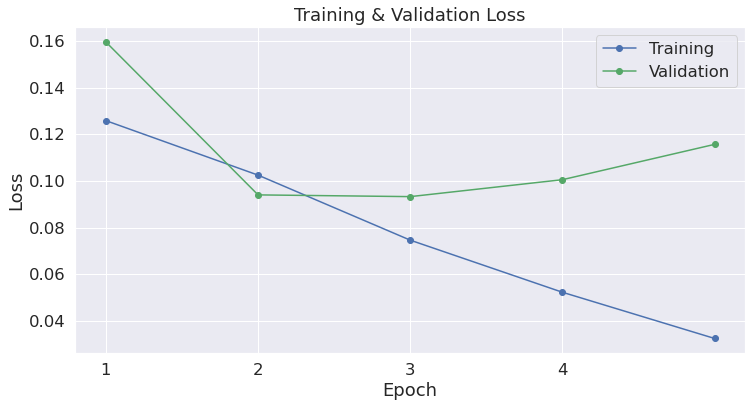

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [25]:
# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = '/home/napat/nlp/weight_gen'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training

Saving model to /home/napat/nlp/weight_gen


('/home/napat/nlp/weight_gen/tokenizer_config.json',
 '/home/napat/nlp/weight_gen/special_tokens_map.json',
 '/home/napat/nlp/weight_gen/vocab.json',
 '/home/napat/nlp/weight_gen/merges.txt',
 '/home/napat/nlp/weight_gen/added_tokens.json')

## load a model 

In [13]:
# # Load a trained model and vocabulary that you have fine-tuned
output_dir = '/home/napat/nlp/weight_gen'
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model = model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50272, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [15]:
model.eval()
#Sleeping Shaq mute my feelings before quarantine
prompt = "<|startoftext|>[Drake Hotline Bling] me"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.cuda()

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50262,  1326]], device='cuda:0')
0: <|startoftext|> [Drake Hotline Bling] me staying healthy me <SEP> making dumb frickin memes at 3am<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


1: <|startoftext|> [Drake Hotline Bling] me when i get corona <SEP> me when i get corona<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


2: <|startoftext|> [Drake Hotline Bling] me getting banned on roblox <SEP> flamingo albert getting banned on roblox<|endoftext|>




In [ ]:
from nlp import load_dataset
test = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
encodings = tokenizer('\n\n'.join(test['text']), return_tensors='pt')

In [59]:
from tqdm import tqdm
max_length = model.config.n_positions
stride = 64

lls = []
for i in tqdm(range(0, len(encodings), stride)):
    begin_loc = max(i + stride - max_length, 0)
    end_loc = min(i + stride, len(encodings))
    trg_len = end_loc - i    # may be different from stride on last loop
    input_ids = encodings[begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        log_likelihood = outputs[0] * trg_len

    lls.append(log_likelihood)

ppl = torch.exp(torch.stack(lls).sum() / end_loc)

100%|██████████| 371/371 [00:15<00:00, 24.08it/s]


In [60]:
ppl

tensor(7271.3682, device='cuda:0')

## generate

In [63]:
model.eval()
#Sleeping Shaq mute my feelings before quarantine
df = []
for classes in additional_special_class_meme:
    prompt = "<|startoftext|>"+classes

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.cuda()

    print(generated)

    sample_outputs = model.generate(
                                    generated, 
                                    #bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=100, 
                                    max_length = 100,
                                    top_p=0.95, 
                                    num_return_sequences=100
                                    )
    
    for i, sample_output in enumerate(sample_outputs):
        #print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=False)))
        df.append([classes,tokenizer.decode(sample_output, skip_special_tokens=False)])
    #break
df = pd.DataFrame(np.array(df),columns = ['classes','generated text'])
df.to_csv('text_gen.csv')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50260]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50261]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50262]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50263]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50264]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50265]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50266]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50267]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50268]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50269]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50270]], device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50271]], device='cuda:0')


In [28]:
x =val_dataset[0][0]
x[0:torch.sum(val_dataset[0][1])]

tensor([50257, 50269, 34952,  1118,   481,   510, 27257,   428, 25336, 50258,
        50256])

In [55]:
encodings = torch.tensor([])
for i in range(2155):
    encodings = torch.cat([encodings,val_dataset[i][0][0:torch.sum(val_dataset[0][1])]])
encodings

tensor([50257., 50269., 34952.,  ..., 40965.,   262.,  2694.])

In [56]:
encodings = encodings.long()
encodings

tensor([50257, 50269, 34952,  ..., 40965,   262,  2694])

## perplexity

In [29]:
def score(idx,dataset):
    import math
    tensor_input = dataset[idx][0][0:torch.sum(dataset[idx][1])].cuda()
    model.eval()
    with torch.no_grad():
        loss=model(tensor_input, labels=tensor_input)
    #print(loss[0])
    return math.exp(loss[0])
avg =0
for i in range(len(val_dataset)):
    avg +=score(i,val_dataset)
print(f'val set : ppl = {avg/len(val_dataset)}')

val set : ppl = 147.19083962799075


In [30]:
avg =0
for i in range(len(train_dataset)):
    avg +=score(i,train_dataset)
print(f'training set : ppl = {avg/len(train_dataset)}')

training set : ppl = 10.769821056624666
